# 1. 에일리언 vs 프레데터 데이터셋
* https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
* 케글 로그인 -> 계정 클릭 -> Your Profile -> Account -> API 항목에 Create New API Token -> json을 다운로드
* {"username":"baekjimyoung","key":"e88be0e14f1868098160f7f546eb5ddb"}

In [ ]:
import os

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'baekjimyoung' # username
os.environ['KAGGLE_KEY'] = 'e88be0e14f1868098160f7f546eb5ddb' # key

In [ ]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images
!unzip -q alien-vs-predator-images.zip

alien-vs-predator-images.zip: Skipping, found more recently modified local copy (use --force to force download)
replace alien_vs_predator_thumbnails/data/train/alien/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. 이미지 증강 기법(Image Augmentation)
* 원본 이미지(데이터)를 조작하여 원본과는 크고 작은 변화를 가진 이미지를 생성
    * 일반적으로 모델 성능이 좋아짐
    * Over fitting 방지
* https://pytorch.org/vision/master/transforms.html

In [38]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [ ]:
def target_transforms(target):
    return torch.FloatTensor([target])

In [ ]:
image_datasets = {
    'train': datasets.ImageFolder('cats_and_dogs_filtered/train', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('cats_and_dogs_filtered/validation', data_transforms['validation'], target_transform=target_transforms)
}

dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

694 200


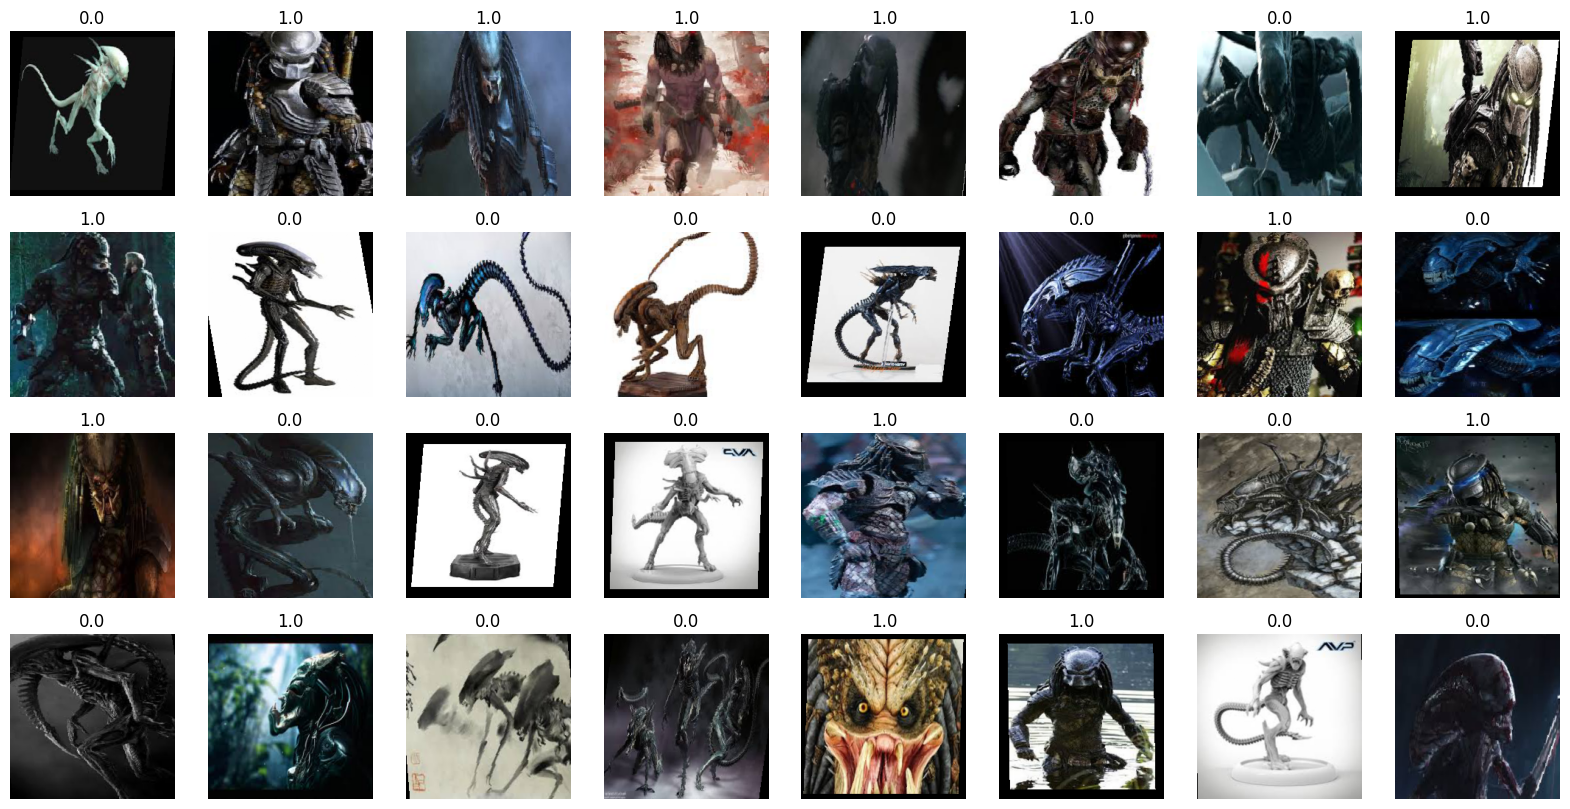

In [ ]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')

# 3. 전이학습(Transfer Learning)
* 하나의 작업을 위해 훈련된 모델을 유사 작업 수행 모델의 시작점으로 활용하는 딥러닝 접근법
* 신경망은 처음부터 새로 학습하는 것보다 전이 학습을 통해 업데이트 하고 재학습하는 편이 더 빠르고 간편함
* 전이 학습은 여러 응용 분야 중에서도 특히 검출, 영상 인식, 음성 인식, 검색 분야에 많이 사용

![](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)

### 3-1. 전이 학습의 고려할 점
* 크기: 모델 크기의 중요성은 모델을 배포할 위치와 방법에 따라 달라짐
* 정확도: 재훈련 전의 모델 성능은 어느 정도인지 확인이 필요
* 예측속도:  하드웨어 및 배치 크기와 같은 다른 딥러닝 요소는 물론 선택된 모델의 아키텍쳐와 모델 크기에 따라서도 달라짐

![](https://kr.mathworks.com/discovery/transfer-learning/_jcr_content/mainParsys/image.adapt.full.medium.jpg/1634621302937.jpg)

# 4. 사전 학습된 ResNet50 모델
* [파이토치에서 제공하는 사전학습 모델들](https://pytorch.org/vision/stable/models.html)

![](https://i.stack.imgur.com/gI4zT.png)

### 4-1. 이미지넷(ImegeNet)
* 이미지 데이터베이스
* 1000개의 동물과 사물 이미지를 포함

![](https://i.imgur.com/5Rz5s8e.png)

In [10]:
# model = models.resnet50(pretrained = True).to(device)
model = models.resnet50(weights = 'IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 299MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 4-2. Freeze Layers
* 특징을 뽑아내는 CNN의 앞쪽 컨볼루션 레어들은 학습을 하지 않도록 설정
* 출력 부분의 레이어(fc)를 다시 설정하여 분류에 맞게 설정

In [14]:
for param in model.parameters():
  param.requires_grad = False # 가져온 파라미터 (W,b)를 업데이트 하지 않음

  model.fc = nn.Sequential(
      nn.Linear(2048, 128),
      nn.ReLU(),
      nn.Linear(128, 1),
      nn.Sigmoid()
  ).to(device)

  print(model)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
      (relu): ReLU(inplace=True)
    )
    (3): Bottleneck(
      (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (layer3): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): 

In [16]:
# 학습: fc 부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

epochs = 10

for epoch in range(epochs):
  for phase in ['train','validation']:
    if phase == 'train':
      model.train()
    else:
      model.eval()

    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[phase]:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)

      loss = nn. BCELoss()(y_pred, y_batch)

      if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      sum_losses = sum_losses + loss.item()

      y_bool = (y_pred >= 0.5).float()
      acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
      sum_accs = sum_accs + acc.item()

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])

    print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 0.1496, Accuracy: 94.18%
validation: Epoch    1/10, Loss: 0.2660, Accuracy: 88.84%
train     : Epoch    2/10, Loss: 0.1526, Accuracy: 94.25%
validation: Epoch    2/10, Loss: 0.1992, Accuracy: 91.52%
train     : Epoch    3/10, Loss: 0.1511, Accuracy: 95.25%
validation: Epoch    3/10, Loss: 0.1914, Accuracy: 92.41%
train     : Epoch    4/10, Loss: 0.1631, Accuracy: 92.99%
validation: Epoch    4/10, Loss: 0.2110, Accuracy: 92.86%
train     : Epoch    5/10, Loss: 0.1555, Accuracy: 93.54%
validation: Epoch    5/10, Loss: 0.2101, Accuracy: 90.62%
train     : Epoch    6/10, Loss: 0.1634, Accuracy: 94.03%
validation: Epoch    6/10, Loss: 0.1893, Accuracy: 91.96%
train     : Epoch    7/10, Loss: 0.1291, Accuracy: 95.04%
validation: Epoch    7/10, Loss: 0.2089, Accuracy: 90.62%
train     : Epoch    8/10, Loss: 0.1447, Accuracy: 94.89%
validation: Epoch    8/10, Loss: 0.1824, Accuracy: 92.86%
train     : Epoch    9/10, Loss: 0.1314, Accuracy: 94.89%
validation: Ep

In [17]:
torch.save(model.state_dict(), 'model.h5')

In [20]:
model = models.resnet50().to(device)

for param in model.parameters():
  param.requires_grad = False # 가져온 파라미터 (W,b)를 업데이트 하지 않음

  model.fc = nn.Sequential(
      nn.Linear(2048, 128),
      nn.ReLU(),
      nn.Linear(128, 1),
      nn.Sigmoid()
  ).to(device)

In [19]:
# 학습: fc 부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

epochs = 10

for epoch in range(epochs):
  for phase in ['train','validation']:
    if phase == 'train':
      model.train()
    else:
      model.eval()

    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[phase]:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)

      loss = nn. BCELoss()(y_pred, y_batch)

      if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      sum_losses = sum_losses + loss.item()

      y_bool = (y_pred >= 0.5).float()
      acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
      sum_accs = sum_accs + acc.item()

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])

    print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 0.7697, Accuracy: 51.76%
validation: Epoch    1/10, Loss: 0.6887, Accuracy: 55.36%
train     : Epoch    2/10, Loss: 0.6943, Accuracy: 51.39%
validation: Epoch    2/10, Loss: 0.6976, Accuracy: 55.36%
train     : Epoch    3/10, Loss: 0.7619, Accuracy: 49.25%
validation: Epoch    3/10, Loss: 0.6877, Accuracy: 55.80%
train     : Epoch    4/10, Loss: 0.6927, Accuracy: 56.88%
validation: Epoch    4/10, Loss: 0.6767, Accuracy: 65.62%
train     : Epoch    5/10, Loss: 0.6799, Accuracy: 54.29%
validation: Epoch    5/10, Loss: 0.6724, Accuracy: 61.61%
train     : Epoch    6/10, Loss: 0.6802, Accuracy: 53.84%
validation: Epoch    6/10, Loss: 0.6707, Accuracy: 57.14%
train     : Epoch    7/10, Loss: 0.6739, Accuracy: 58.38%
validation: Epoch    7/10, Loss: 0.6701, Accuracy: 58.04%
train     : Epoch    8/10, Loss: 0.6961, Accuracy: 52.34%
validation: Epoch    8/10, Loss: 0.6833, Accuracy: 61.61%
train     : Epoch    9/10, Loss: 0.6745, Accuracy: 59.58%
validation: Ep

In [21]:
# 모델 로드
model.load_state_dict(torch.load('model.h5'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
# 학습: fc 부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

epochs = 10

for epoch in range(epochs):
  for phase in ['train','validation']:
    if phase == 'train':
      model.train()
    else:
      model.eval()

    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[phase]:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)

      loss = nn. BCELoss()(y_pred, y_batch)

      if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      sum_losses = sum_losses + loss.item()

      y_bool = (y_pred >= 0.5).float()
      acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
      sum_accs = sum_accs + acc.item()

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])

    print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 0.1297, Accuracy: 94.54%
validation: Epoch    1/10, Loss: 0.1891, Accuracy: 93.30%
train     : Epoch    2/10, Loss: 0.1209, Accuracy: 95.74%
validation: Epoch    2/10, Loss: 0.1909, Accuracy: 92.86%
train     : Epoch    3/10, Loss: 0.1256, Accuracy: 95.53%
validation: Epoch    3/10, Loss: 0.1841, Accuracy: 91.96%
train     : Epoch    4/10, Loss: 0.1415, Accuracy: 95.11%
validation: Epoch    4/10, Loss: 0.1840, Accuracy: 91.52%
train     : Epoch    5/10, Loss: 0.1136, Accuracy: 96.02%
validation: Epoch    5/10, Loss: 0.1899, Accuracy: 91.96%
train     : Epoch    6/10, Loss: 0.1705, Accuracy: 93.01%
validation: Epoch    6/10, Loss: 0.2173, Accuracy: 90.62%
train     : Epoch    7/10, Loss: 0.1201, Accuracy: 95.39%
validation: Epoch    7/10, Loss: 0.1897, Accuracy: 91.52%
train     : Epoch    8/10, Loss: 0.1196, Accuracy: 95.03%
validation: Epoch    8/10, Loss: 0.2045, Accuracy: 92.41%
train     : Epoch    9/10, Loss: 0.1135, Accuracy: 95.04%
validation: Ep

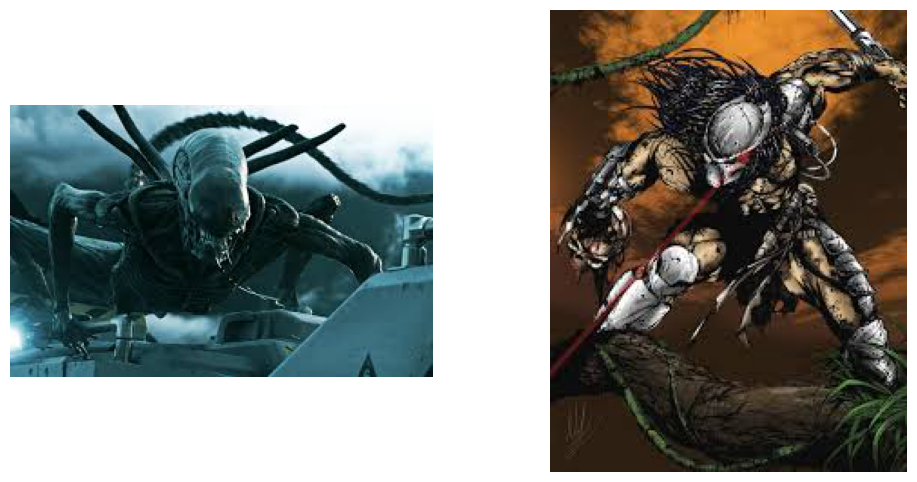

In [31]:
# 테스트
from PIL import Image

img1 = Image.open('/content/data/validation/alien/12.jpg')
img2 = Image.open('/content/data/validation/predator/2.jpg')

fig, axes = plt.subplots(1,2,figsize = (12,6))
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].axis('off')

plt.show()


In [35]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)

test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [34]:
y_pred = model(test_batch)
y_pred

tensor([[0.0030],
        [0.9834]], device='cuda:0', grad_fn=<SigmoidBackward0>)

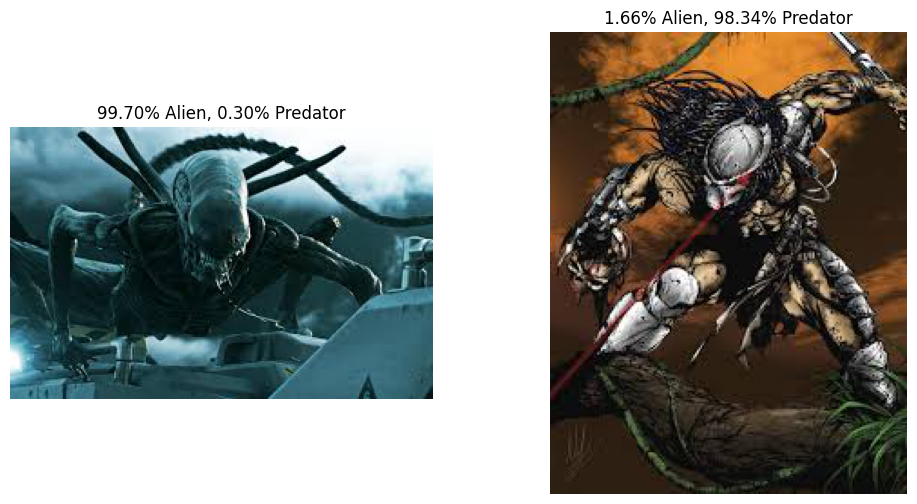

In [39]:
fig, axes = plt.subplots(1,2,figsize = (12,6))

axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title(f'{(1-y_pred[0,0]) * 100:.2f}% cat, {y_pred[0,0] * 100:.2f}% dog')  # 예측 정확도를 타이틀로 추가

axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title(f'{(1-y_pred[1,0]) * 100:.2f}% cat, {y_pred[1,0] * 100:.2f}% dog')  # 예측 정확도를 타이틀로 추가

plt.show()

### 과제
* 전이 학습으로 강아지와 고양이 구분하기
* https://www.kaggle.com/c/dogs-vs-cats


In [55]:
!unzip -q dogs-vs-cats.zip -d data

403 - Forbidden
unzip:  cannot find or open dogs-vs-cats.zip, dogs-vs-cats.zip.zip or dogs-vs-cats.zip.ZIP.


In [56]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-06-20 04:08:51--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  19.6MB/s    in 4.0s    

2023-06-20 04:08:56 (16.3 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [58]:
!unzip -q cats_and_dogs_filtered.zip

In [60]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

def target_transforms(target):
    return torch.FloatTensor([target])

image_datasets = {
    'train': datasets.ImageFolder('cats_and_dogs_filtered/train', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('cats_and_dogs_filtered/validation', data_transforms['validation'], target_transform=target_transforms)
}

dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')

# model = models.resnet50(pretrained = True).to(device)
model = models.resnet50(weights = 'IMAGENET1K_V1').to(device)

for param in model.parameters():
  param.requires_grad = False # 가져온 파라미터 (W,b)를 업데이트 하지 않음

  model.fc = nn.Sequential(
      nn.Linear(2048, 128),
      nn.ReLU(),
      nn.Linear(128, 1),
      nn.Sigmoid()
  ).to(device)

# 학습: fc 부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

epochs = 10

for epoch in range(epochs):
  for phase in ['train','validation']:
    if phase == 'train':
      model.train()
    else:
      model.eval()

    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in dataloaders[phase]:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)

      loss = nn. BCELoss()(y_pred, y_batch)

      if phase == 'train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      sum_losses = sum_losses + loss.item()

      y_bool = (y_pred >= 0.5).float()
      acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
      sum_accs = sum_accs + acc.item()

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])

    print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')


# 테스트
from PIL import Image

img1 = Image.open('/content/cats_and_dogs_filtered/validation/cats/cat.2003.jpg')
img2 = Image.open('/content/cats_and_dogs_filtered/validation/dogs/dog.2004.jpg')

img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)

test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)

y_pred = model(test_batch)

fig, axes = plt.subplots(1,2,figsize = (12,6))

axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title(f'{(1-y_pred[0,0]) * 100:.2f}% cat, {y_pred[0,0] * 100:.2f}% dog')  # 예측 정확도를 타이틀로 추가

axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title(f'{(1-y_pred[1,0]) * 100:.2f}% cat, {y_pred[1,0] * 100:.2f}% dog')  # 예측 정확도를 타이틀로 추가

plt.show()


Output hidden; open in https://colab.research.google.com to view.

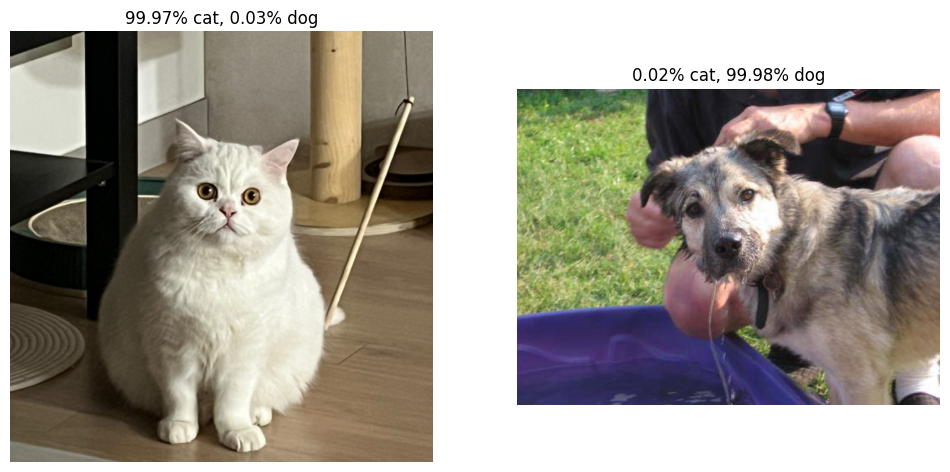

In [70]:
from PIL import Image

img1 = Image.open('/content/cats_and_dogs_filtered/validation/cats/image (1).png')
img2 = Image.open('/content/cats_and_dogs_filtered/validation/dogs/dog.2004.jpg')

img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)

# test_batch = torch.stack([img1_input, img2_input])
# test_batch = test_batch.to(device)


y_pred = model(test_batch)

fig, axes = plt.subplots(1,2,figsize = (12,6))

axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title(f'{(1-y_pred[0,0]) * 100:.2f}% cat, {y_pred[0,0] * 100:.2f}% dog')  # 예측 정확도를 타이틀로 추가

axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title(f'{(1-y_pred[1,0]) * 100:.2f}% cat, {y_pred[1,0] * 100:.2f}% dog')  # 예측 정확도를 타이틀로 추가

plt.show()
